In [1]:
import numpy as np
#import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import h5py

In [5]:
from uatu.scattering import *

/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [6]:
from scipy.ndimage import gaussian_filter
from lenstools import GaussianNoiseGenerator, ConvergenceMap
from astropy.units import deg

In [7]:
model_path = '/home/sean/Git/uatu/networks/deep_resnet_smooth_1.0_noise_0.3_05_adv.pth'

In [8]:
#downsample_factor = 4
shape = (256, 256)
in_channels = 1
width = 2

depth = 5#[16, 32, 64, 64, 64, 64, 64]

In [9]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [10]:
model = DeepResnet(input_size = shape[0], in_channels=in_channels, n_subplanes=width, depth=depth, shuffle_layers=3).to(device)

Appending Shuffle Block


In [458]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [459]:
model.eval();

In [460]:
def log_barrier(x_p, x_o, eps=0.5, lam=5e2):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=2) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [461]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [462]:
def get_embedding(x, model):

    x = x.view(1, model.K, model.input_size, model.input_size)#
    x = model.init_conv(x)

    for l in model.layers:
        x = l(x)

    x = model.avgpool(x)
    #x = x.view(x.size(0), -1)
    ##x = model.fc(x)
    return x


In [463]:
def get_pred(x, model):

    return model(x) # same as getting the embedding of the final output layer


In [464]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=10*deg)
    l1, psd1D = cmap.powerSpectrum(l)

    return l1, psd1D#/psd1D[0]

In [465]:
def image_pc(image):
    #image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=10*deg)
    thresholds = np.linspace(-0.01, 0.04,  81)
    #thresholds = np.linspace(-5, 5, 200)
    nu,peaks = cmap.peakCount(thresholds, norm=False)
    return nu, peaks#/psd1D[0]

In [466]:
def compute_robust_map(model, x0, xt, embedding_func, steps=1): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0 = x0.to(device)#, xt.to(device)
    xt = xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    # Forward pass the data through the model
    init_pred = embedding_func(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon = 1e-4#5e-5
    # TODO figure out how to use one of these here... 
    optimizer = torch.optim.Adam([perturbed_x0], lr=epsilon)#, weight_decay=1e-9)

    for i in range(steps):
        #optimizer.zero_grad()

        output = embedding_func(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm()+ log_barrier(perturbed_x0, x0) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)

        loss.backward(retain_graph = True)

        #optimizer.step()
        
        if i%100==0:
            print(loss)
            epsilon*=0.5
            #optimizer = torch.optim.Adam([perturbed_x0], lr=epsilon)#, weight_decay=1e-9)

        x0_grad = perturbed_x0.grad.data
        perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    output = embedding_func(perturbed_x0, model)
    return perturbed_x0, init_pred, output

In [467]:
smooth = 1
noise = 0.29#29
shape_noise = noise/np.sqrt((2.34**2)*30) #sigma_e/sqrt(A*n)
np.random.seed(0)
data_mod = lambda x: np.log10(gaussian_filter(x+np.random.randn(*x.shape)*shape_noise, smooth)+1.0) # add a normalization, hopefully sufficient
transform = torch.Tensor

In [468]:
all_test_ys = np.zeros((50,2))
with h5py.File('/home/sean/Git/uatu/data/UatuFastPMTest.hdf5', 'r') as f:
    for i in range(50):
        all_test_ys[i] = f['Box%03d'%i]['Y'][0].squeeze()

In [469]:
mean_y = all_test_ys.mean(axis=0)
fid_idx = np.argmin(np.sum((all_test_ys - mean_y)**2, axis=1) )

In [470]:
orig_cosmo_idx = 0#fid_idx
orig_map_idx = 128
target_cosmo_idx = fid_idx#0
target_map_idx = 512

In [471]:
def load_data(cosmo_idx, map_idx):
    with h5py.File('/home/sean/Git/uatu/data/UatuFastPMTest.hdf5', 'r') as f:
        X = f['Box%03d'%cosmo_idx]['X'][map_idx].squeeze()
        y = f['Box%03d'%cosmo_idx]['Y'][map_idx].squeeze()
            
    return data_mod(X),y

In [472]:
X_orig, y_orig = load_data(orig_cosmo_idx, orig_map_idx)

In [473]:
X_targ, y_targ = load_data(target_cosmo_idx, target_map_idx)

In [474]:
X_orig = np.random.randn(*X_orig.shape).squeeze()*X_targ.std()+X_targ.mean()

In [475]:
#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 10 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
l, Pl = image_ps(X_targ.squeeze())

In [476]:
#Instantiate the gaussian noise generator
#http://www.columbia.edu/~ap3020/LensTools/html/examples/gaussian_random_field.html
gen = GaussianNoiseGenerator(shape=(num_pixel_side,num_pixel_side),side_angle=side_angle)
gaussian_map = gen.fromConvPower(np.array([l,Pl]),seed=1,kind="linear",bounds_error=False,fill_value=0.0)
X = gaussian_map.data
X_orig = ((X- X.mean())/X.std() )*X_targ.std() + X_targ.mean()

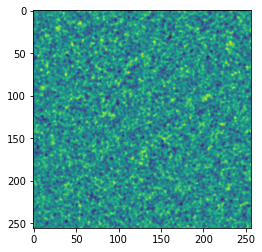

In [477]:
plt.imshow(X_orig.squeeze())

In [478]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X_orig ).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(X_targ).reshape((1, shape[0], shape[1])), 
                                  #torch.Tensor(y_targ).to(device),
                                    get_embedding,#get_pred,
                                    500)#,\

tensor(2.3648, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


In [479]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [480]:
init_pred = model(torch.Tensor(X_orig ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()
init_targ_pred = model(torch.Tensor(X_targ ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()
final_targ_pred = model(torch.Tensor(X_robust ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()

In [481]:
init_pred, y_orig

(array([0.36783624, 0.5969958 ], dtype=float32), array([0.163058, 0.654217]))

In [482]:
#robust_embed, y_targ

In [483]:
vmin, vmax = X_orig.min()*1.1, X_orig.max()*1.1

In [484]:
vmin, vmax

(-0.012383715943525817, 0.012668447020251918)

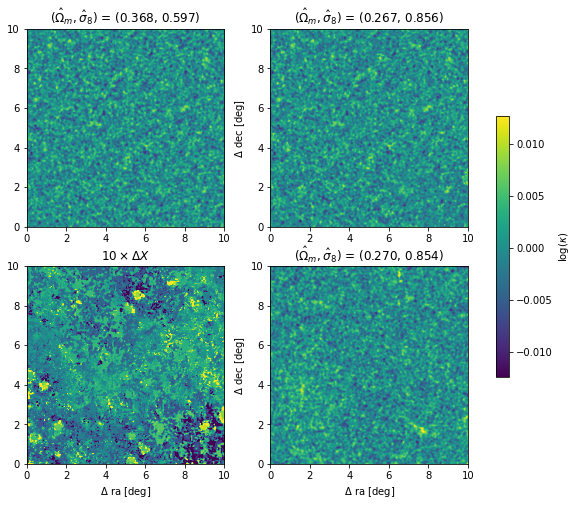

In [485]:
#fig = plt.figure(figsize = (16,4))
fig, axes = plt.subplots(2,2,figsize=(10,8))

#plt.title('Orig Image')
axes[0][0].imshow(X_orig.squeeze(), vmin = vmin, vmax= vmax,extent=[0,10,0,10])
axes[0][0].set_title(r'($\hat{\Omega}_m, \hat{\sigma}_8$) = (%0.3f, %0.3f)'%(init_pred[0], init_pred[1]) )
#plt.title('Diff Image')
axes[1][0].imshow(10*(X_robust.squeeze()-X_orig.squeeze() ), vmin = vmin, vmax= vmax,extent=[0,10,0,10])
axes[1][0].set_title(r'$10 \times \Delta X$')
#plt.title('Perturbed Image')
im = axes[0][1].imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax,extent=[0,10,0,10])
axes[0][1].set_title(r'($\hat{\Omega}_m, \hat{\sigma}_8$) = (%0.3f, %0.3f)'%(final_targ_pred[0], final_targ_pred[1]) )

im = axes[1][1].imshow(X_targ.squeeze(), vmin = vmin, vmax= vmax,extent=[0,10,0,10])
axes[1][1].set_title(r'($\hat{\Omega}_m, \hat{\sigma}_8$) = (%0.3f, %0.3f)'%(init_targ_pred[0], init_targ_pred[1]) )

fig.colorbar(im, ax=axes.ravel().tolist(), shrink = 0.6, label = r'$\log(\kappa)$')

for i in range(2):
    for j in range(2):
        #if i ==1 and j ==1 :
        #    continue
        axes[1][i].set_xlabel(r'$\Delta$ ra [deg]')
        axes[i][1].set_ylabel(r'$\Delta$ dec [deg]')


In [486]:
def plot_ps(X_orig, X_target, X_attack):
    
    fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
    l, attacked_ps = image_ps(X_attack.squeeze())
    _,target_ps = image_ps(X_target.squeeze())
    _,normal_ps = image_ps(X_orig.squeeze())
    _,diff_ps = image_ps((X_attack.squeeze()- X_orig.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    axes[0].plot(l,attacked_ps, label = 'Attacked' )
    axes[0].plot(l,target_ps, label = 'Target')
    axes[0].plot(l,normal_ps, label = 'Original')
    axes[0].set_ylabel('$P(l)$')
    #plt.plot(diff_ps, label = 'Diff')

    axes[0].legend(loc='best', frameon=False)
    axes[0].loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    axes[1].plot(l,attacked_ps/normal_ps, label = 'Attacked/Original')
    axes[1].plot(l,target_ps/normal_ps, label = 'Target/Original')
    axes[1].legend(loc='best')
    axes[1].loglog()
    axes[1].set_ylabel('$P(l)/P_{orig}(l)$')
    axes[1].set_xlabel(r'$l\; \mathrm{[h/Mpc]}$')
    #plt.ylim([0.4, 6])
    plt.show();

In [487]:
def plot_pc(X_orig, X_target, X_attack):
    
    fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
    nu, attacked_pc = image_pc(X_attack.squeeze())
    #nu = (nu[:1]+nu[:-1])/2.0

    _,target_pc = image_pc(X_target.squeeze())
    _,normal_pc = image_pc(X_orig.squeeze())
    _,diff_pc = image_pc((X_attack.squeeze()- X_orig.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    axes[0].plot(nu,attacked_pc, label = 'Attacked' )
    axes[0].plot(nu,target_pc, label = 'Target')
    axes[0].plot(nu,normal_pc, label = 'Original')
    axes[0].set_ylabel('Peak Counts')
    axes[0].set_yscale('log')
    #plt.plot(diff_ps, label = 'Diff')

    axes[0].legend(loc='best', frameon=False)
    #axes[0].loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    axes[1].plot(nu,attacked_pc/normal_pc, label = 'Attacked/Original')
    axes[1].plot(nu, target_pc/normal_pc, label = 'Target/Original')
    axes[1].legend(loc='best')
    #axes[1].loglog()
    axes[1].set_ylabel('$Peak Counts Ratio$')
    axes[1].set_xlabel(r'$\kappa$') # todo unites?
    #plt.ylim([0.4, 6])
    plt.show();

/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


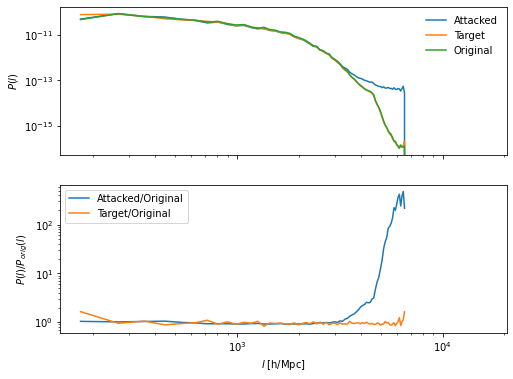

In [488]:
plot_ps(X_orig, X_targ, X_robust)

/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


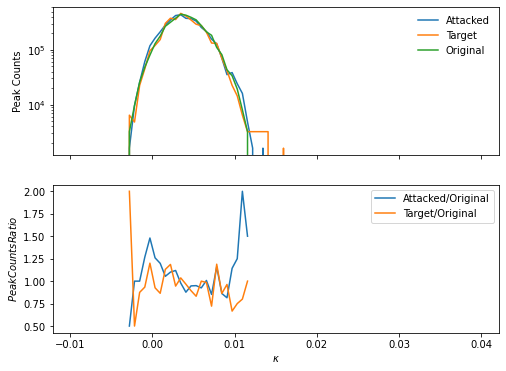

In [489]:
plot_pc(X_orig, X_targ, X_robust)